In [0]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
from torch import optim

In [0]:
df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)
df.head()
print(len(df))
# df = batch[:7000]

6920


In [0]:
train_samples, test_samples, _, _ = train_test_split(df[0], df[1], stratify=df[1])
print(train_samples.shape, test_samples.shape)

(5190,) (1730,)


In [0]:
!mkdir train

with open('train/train_data.txt', 'w') as f:
  lines = [value + '\n' for value in train_samples]
  f.writelines(lines)

with open('train/eval_data.txt', 'w') as f:
  lines = [value + '\n' for value in test_samples]
  f.writelines(lines)



mkdir: cannot create directory ‘train’: File exists


In [0]:
with open('train/train_data.txt') as f:
  lines = f.readlines()

print(len(lines))

5190


In [0]:
df[1].value_counts()

1    3610
0    3310
Name: 1, dtype: int64

## Loading Tranformer Components

In [0]:
!pip install pytorch-transformers
!pip install transformers
!git clone https://github.com/huggingface/transformers

     |████████████████████████████████| 184kB 2.9MB/s 
     |████████████████████████████████| 860kB 47.5MB/s 
     |████████████████████████████████| 1.0MB 46.2MB/s 
     |████████████████████████████████| 675kB 51.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=0b7ea1461ed4e6c237686847e581f9f9010101640e44eba7cc2bce1ed1b7cb3e
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
  Created wheel for regex: filename=regex-2019.12.9-cp36-cp36m-linux_x86_64.whl size=609180 sha256=916082004fd0ce16fc25bb868ccf049ac19fb1ee78aa5fec59ebf1fb83b59ef5
  Stored in directory: /root/.cache/pip/wheels/0d/fb/b3/a89169557229468c49ca64f6839418f22461f6ee0a74f342b1
Successfully built sacremoses regex
     |████████████████████████████████| 368kB 2.8MB/s 
Cloning into 'transformers'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 10

In [0]:
from pytorch_transformers import AdamW
from pytorch_transformers import DistilBertModel, DistilBertForSequenceClassification, DistilBertTokenizer
from pytorch_transformers import BertModel, BertForSequenceClassification, BertTokenizer
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, RandomSampler, DataLoader
from tqdm import tqdm, trange

In [0]:
device = torch.device('cuda')
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

## NN Instance

In [0]:
class ffn(nn.Module):

  def __init__(self, input_dim):
    super().__init__()
    torch.manual_seed(42)
    self.net = nn.Sequential(
        nn.Linear(input_dim, 1000),
        # nn.BatchNorm1d(1000),
        nn.Dropout(0.4),
        nn.ReLU(),
        nn.Linear(1000, 500),
        # nn.BatchNorm1d(500),
        nn.Dropout(0.4),
        nn.ReLU(),
        nn.ReLU(),
        nn.Linear(500, 2),
        nn.Softmax()
    )

  def forward(self, X):
    return self.net(X)

def accuracy(y_hat, y):
  pred = torch.argmax(y_hat, dim=1)
  return (pred==y).float().mean()

def fit(data, labels, model, opt, loss_fn, do_validation=False, val_data=None, val_labels=None, epochs=1000):
  loss_arr = []
  acc_arr = []
  validation_loss = []
  validation_acc = []
  for epoch in range(epochs):
    loss = loss_fn(model(data), labels)

    if epoch%100 == 0:
      loss_arr.append(loss.item())
      acc_arr.append(accuracy(model(data), labels).item())

      if do_validation:
        validation_acc.append(accuracy(model(val_data), val_labels).item())
        validation_loss.append(loss_fn(model(val_data), val_labels))

    loss.backward()
    opt.step()
    opt.zero_grad()
    
  plt.plot(loss_arr, 'r-')
  plt.plot(acc_arr, 'b-')
  if do_validation:
    plt.plot(validation_acc, 'y-')
    plt.plot(validation_loss, 'y-')

  # print('Training Accuracy: ', acc_arr[-1])
  # print('Validation Accuracy: ', validation_acc[-1])
  output = acc_arr[-1]

  del loss_arr, acc_arr, validation_loss, validation_acc
  return output


In [0]:
loss_fn = nn.CrossEntropyLoss()

## Using DistilBert Sequence Classification Model directly

In [0]:
## Loading Tokenizer and Model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# model = DistilBertModel.from_pretrained('distilbert-base-uncased')
# sequence_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
sequence_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
sequence_model.cuda()

output_labels = []
batch_size = 32
for i in range(int(df.shape[0]/batch_size)+1):
  tokenized = [tokenizer.encode(element, add_special_tokens=True) for element in df.loc[batch_size*i:batch_size*(i+1)-1, 0]]

  ## Padding
  max_len = 67

  # for value in tokenized:
  #   if len(value) > max_len:
  #     max_len = len(value)

  tokenized = np.array([i + [0]*(max_len - len(i)) for i in tokenized])
  # print(tokenized.shape)

  ## Attention Mark
  attention_mask = np.where(tokenized != 0, 1, 0)

  ## Converting input to tensor to use by sequence model
  input_ids = torch.tensor(tokenized)
  attention = torch.tensor(attention_mask) 
  labels = torch.tensor(df.loc[batch_size*i:batch_size*(i+1)-1, 1].values)

  input_ids = input_ids.to(device)
  attention = attention.to(device)
  labels = labels.to(device)

  del tokenized, attention_mask
  torch.cuda.empty_cache()

  with torch.no_grad():
    outputs = sequence_model(input_ids, attention_mask=attention, labels=labels)
  
  output_labels.extend(outputs[1].cpu().numpy())

  # print(outputs[1].shape)
  # print('iteration complete: ', i)


100%|██████████| 440473133/440473133 [00:07<00:00, 62664480.47B/s]


In [0]:
print(len(output_labels))
print(accuracy_score(df[1], np.argmax(np.asarray(output_labels), axis=1)))

6920
0.47832369942196534


## Fine-training DistilBert Sequence Classification Model

In [0]:
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenized = [tokenizer.encode(element, add_special_tokens=True) for element in df[0]]

## Padding
max_len = 0

for value in tokenized:
  if len(value) > max_len:
    max_len = len(value)

tokenized = np.array([i + [0]*(max_len - len(i)) for i in tokenized])
print(tokenized.shape)

## Attention Mark
attention_mask = np.where(tokenized != 0, 1, 0)

train_data, validation_data, train_labels, validation_labels = train_test_split(tokenized, df[1].values, stratify=df[1], random_state=42)
train_masks, validation_masks, _, _ = train_test_split(attention_mask, df[1].values, stratify=df[1], random_state=42)
print(train_data.shape, train_labels.shape)

train_data = torch.tensor(train_data).to(device)
validation_data = torch.tensor(validation_data).to(device)
train_labels = torch.tensor(train_labels).to(device)
validation_labels = torch.tensor(validation_labels).to(device)
train_masks = torch.tensor(train_masks).to(device)
validation_masks = torch.tensor(validation_masks).to(device)

batch_size=32

training_data = TensorDataset(train_data, train_masks, train_labels)
train_sampler = RandomSampler(training_data)
train_dataloader = DataLoader(training_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(validation_data, validation_masks, validation_labels)
validation_sampler = RandomSampler(val_data)
validation_dataloader = DataLoader(val_data, sampler=validation_sampler, batch_size=batch_size)

# model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.cuda()

(6920, 67)
(5190, 67) (5190,)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
# t# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 2

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels) # outputs = (loss, logits) Tuple
    loss = outputs[0]
    if step == 0:
      print('\n', loss)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, attention_mask=b_input_mask) # outputs = (logits) Tuple
      # print(outputs)

    # Move logits and labels to CPU
    logits = outputs[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]


 tensor(0.7373, device='cuda:0', grad_fn=<NllLossBackward>)
Train loss: 0.38654324604324036


Epoch:  50%|█████     | 1/2 [00:43<00:43, 43.68s/it]

Validation Accuracy: 0.9107954545454545

 tensor(0.1303, device='cuda:0', grad_fn=<NllLossBackward>)
Train loss: 0.17302891600625647


Epoch: 100%|██████████| 2/2 [01:27<00:00, 43.68s/it]

Validation Accuracy: 0.9011363636363636


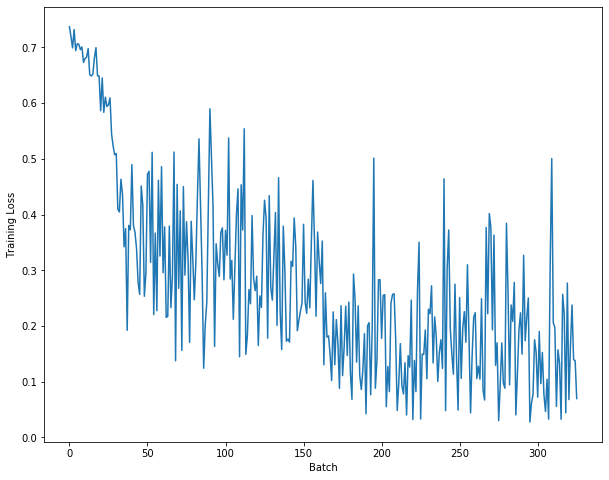

In [0]:
plt.figure(figsize=(10,8))
plt.xlabel('Batch')
plt.ylabel('Training Loss')
plt.plot(train_loss_set)
plt.show()

In [0]:
train_accuracy = 0
nb_train_steps = 0
for batch in train_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up validation
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, attention_mask=b_input_mask) # outputs = (logits) Tuple
    # print(outputs)

  # Move logits and labels to CPU
  logits = outputs[0].detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  tmp_train_accuracy = flat_accuracy(logits, label_ids)
  
  train_accuracy += tmp_train_accuracy
  nb_train_steps += 1

print("Training Accuracy: {}".format(train_accuracy/nb_train_steps))

eval_accuracy = 0
nb_eval_steps = 0
for batch in validation_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up validation
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, attention_mask=b_input_mask) # outputs = (logits) Tuple
    # print(outputs)

  # Move logits and labels to CPU
  logits = outputs[0].detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  tmp_eval_accuracy = flat_accuracy(logits, label_ids)
  
  eval_accuracy += tmp_eval_accuracy
  nb_eval_steps += 1

print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Training Accuracy: 0.9850460122699386
Validation Accuracy: 0.9011363636363636


In [0]:
import os

torch.save(model.state_dict(), 'pytorch_distilbert_model.bin')
model.config.to_json_file('config.json')
tokenizer.save_vocabulary(os.getcwd())

('/content/vocab.txt',)

## Using DistillBertModel to get cls token output as features to build classification models using labels

In [0]:
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenized = [tokenizer.encode(element, add_special_tokens=True) for element in df[0]]

## Padding
max_len = 0

for value in tokenized:
  if len(value) > max_len:
    max_len = len(value)

tokenized = np.array([i + [0]*(max_len - len(i)) for i in tokenized])
print(tokenized.shape)

## Attention Mark
attention_mask = np.where(tokenized != 0, 1, 0)

## labels
labels = df[1].values

batch_size=32

tokenized = torch.tensor(tokenized).to(device)
attention_mask = torch.tensor(attention_mask).to(device)
labels = torch.tensor(labels).to(device)

training_data = TensorDataset(tokenized, attention_mask, labels)
train_sampler = RandomSampler(training_data)
train_dataloader = DataLoader(training_data, sampler=train_sampler, batch_size=batch_size)

# model = DistilBertModel.from_pretrained('distilbert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.cuda()

features = None
feature_labels = None
for step, batch in enumerate(train_dataloader):

  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      last_hidden_states = model(b_input_ids, attention_mask=b_input_mask)

  if step==0:
    features = last_hidden_states[0][:,0,:].cpu().numpy()
    feature_labels = b_labels.cpu().numpy()
  else:
    features = np.concatenate((features, last_hidden_states[0][:,0,:].cpu().numpy()), axis=0)
    feature_labels = np.concatenate((feature_labels, b_labels.cpu().numpy()), axis=0)


(6920, 67)


In [0]:
# labels = df[1].values
train_features, test_features, train_labels, test_labels = train_test_split(features, feature_labels, stratify=feature_labels)
print(train_features.shape, train_labels.shape)

# xgb_model = XGBClassifier()
# xgb_model.fit(train_features, train_labels)

# pred = xgb_model.predict(test_features)
# print(accuracy_score(test_labels, pred))

# pred = xgb_model.predict(train_features)
# print(accuracy_score(train_labels, pred))

(5190, 768) (5190,)


In [0]:
lr_clf = LogisticRegression(C=5)
lr_clf.fit(train_features, train_labels)

# parameters = {'C': np.linspace(0.0001, 100, 20)}
# grid_search = GridSearchCV(LogisticRegression(), parameters)
# grid_search.fit(train_features, train_labels)

# print('best parameters: ', grid_search.best_params_)
# print('best scrores: ', grid_search.best_score_)

print(lr_clf.score(test_features, test_labels))
print(lr_clf.score(train_features, train_labels))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8479768786127168
0.9121387283236995


## Use DistilBertModel to get sentence vector by taking average of all the word vectors or concating all the word vectors

In [0]:
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenized = [tokenizer.encode(element, add_special_tokens=True) for element in df[0]]

## Padding
max_len = 0

for value in tokenized:
  if len(value) > max_len:
    max_len = len(value)

tokenized = np.array([i + [0]*(max_len - len(i)) for i in tokenized])
print(tokenized.shape)

## Attention Mark
attention_mask = np.where(tokenized != 0, 1, 0)

## labels
labels = df[1].values

batch_size=32

tokenized = torch.tensor(tokenized).to(device)
attention_mask = torch.tensor(attention_mask).to(device)
labels = torch.tensor(labels).to(device)

training_data = TensorDataset(tokenized, attention_mask, labels)
train_sampler = RandomSampler(training_data)
train_dataloader = DataLoader(training_data, sampler=train_sampler, batch_size=batch_size)

# model = DistilBertModel.from_pretrained('distilbert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.cuda()

features = []
feature_labels = []
for step, batch in enumerate(train_dataloader):

  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      last_hidden_states = model(b_input_ids, attention_mask=b_input_mask)

  # print(last_hidden_states[0][:,1:,:].size())
  # print(last_hidden_states[0][:,1:,:].sum(dim=1).size())

  if step==0:
    features = last_hidden_states[0][:,:,:].cpu().numpy()
    feature_labels = b_labels.cpu().numpy()
  else:
    features = np.concatenate((features, last_hidden_states[0][:,:,:].cpu().numpy()), axis=0)
    feature_labels = np.concatenate((feature_labels, b_labels.cpu().numpy()), axis=0)


(6920, 67)


In [0]:
print(features.shape)

features_average = np.sum(features, axis=1) / 67  ## normalizing after adding 66 word embedding to generate sentence vector
print(features_average.shape)

features_concat = features.reshape(features.shape[0],-1)
print(features_concat.shape)

(6920, 67, 768)
(6920, 768)
(6920, 51456)


### Sentence Vector generation by averaging all the word embedding

In [0]:
train_features, test_features, train_labels, test_labels = train_test_split(features_average, feature_labels, stratify=feature_labels, random_state=42)
print(train_features.shape, train_labels.shape)

lr_clf = LogisticRegression(C=5)
lr_clf.fit(train_features, train_labels)

# parameters = {'C': np.linspace(0.0001, 100, 20)}
# grid_search = GridSearchCV(LogisticRegression(), parameters)
# grid_search.fit(train_features, train_labels)

# print('best parameters: ', grid_search.best_params_)
# print('best scrores: ', grid_search.best_score_)

print(lr_clf.score(test_features, test_labels))
print(lr_clf.score(train_features, train_labels))

# xgb_model = XGBClassifier(max_depth=3)
# xgb_model.fit(train_features, train_labels)

# pred = xgb_model.predict(test_features)
# print(accuracy_score(test_labels, pred))

# pred = xgb_model.predict(train_features)
# print(accuracy_score(train_labels, pred))

(5190, 768) (5190,)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8531791907514451
0.9190751445086706


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.9749518036842346
0.8624277114868164


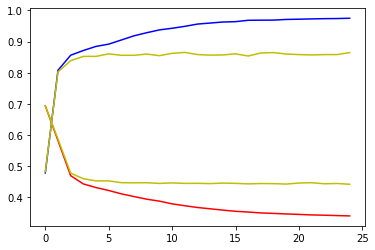

In [0]:
## NN tuning

train_features_torch = torch.tensor(train_features).to(device)
train_labels_torch = torch.tensor(train_labels).to(device)
test_features_torch = torch.tensor(test_features).to(device)
test_labels_torch = torch.tensor(test_labels).to(device)

fn = ffn(train_features.shape[1])
fn.to(device)

opt = optim.Adam(fn.parameters(), lr=0.00002, weight_decay=0.000000001)
do_validation = True
print(fit(train_features_torch, train_labels_torch, fn, opt, loss_fn, do_validation, test_features_torch, test_labels_torch, epochs=2500))
print(accuracy(fn(test_features_torch), test_labels_torch).item())

### Sentence Vector generation by concatenating all the word embedddings

In [0]:
train_features, test_features, train_labels, test_labels = train_test_split(features_concat, feature_labels, stratify=feature_labels, random_state=42)
print(train_features.shape, train_labels.shape)

pca = PCA(0.95)
pca.fit(train_features)
train_features_pca = pca.transform(train_features)
test_features_pca = pca.transform(test_features)
# print(pca.explained_variance_ratio_)
print(train_features_pca.shape, test_features_pca.shape)

lr_clf = LogisticRegression(C=5, solver = 'lbfgs')
lr_clf.fit(train_features_pca, train_labels)

# parameters = {'C': np.linspace(0.0001, 100, 20)}
# grid_search = GridSearchCV(LogisticRegression(), parameters)
# grid_search.fit(train_features, train_labels)

# print('best parameters: ', grid_search.best_params_)
# print('best scrores: ', grid_search.best_score_)

print(lr_clf.score(test_features_pca, test_labels))
print(lr_clf.score(train_features_pca, train_labels))

# xgb_model = XGBClassifier(max_depth=3)
# xgb_model.fit(train_features, train_labels)

# pred = xgb_model.predict(test_features)
# print(accuracy_score(test_labels, pred))

# pred = xgb_model.predict(train_features)
# print(accuracy_score(train_labels, pred))

(5190, 51456) (5190,)
(5190, 3139) (1730, 3139)
0.8138728323699422
1.0


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.9953757524490356
tensor(0.8185, device='cuda:0')


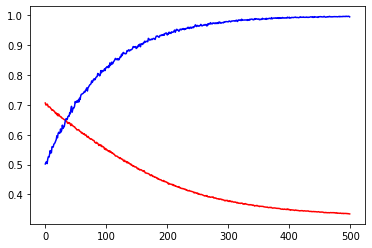

In [0]:
## NN tuning

train_features_torch = torch.tensor(train_features_pca).to(device)
train_labels_torch = torch.tensor(train_labels).to(device)
test_features_torch = torch.tensor(test_features_pca).to(device)
test_labels_torch = torch.tensor(test_labels).to(device)

fn = ffn(train_features_pca.shape[1])
fn.to(device)

opt = optim.Adam(fn.parameters(), lr=0.00001, weight_decay=0.000000001)
print(fit(train_features_torch, train_labels_torch, fn, opt, loss_fn, epochs=500))
print(accuracy(fn(test_features_torch), test_labels_torch))

## Fine-Tuning DistilBert Language Model to be used for Classification

In [0]:
!export TRAIN_FILE=train/data.txt
# !export TEST_FILE=/path/to/dataset/wiki.test.raw

!python transformers/examples/run_lm_finetuning.py \
    --output_dir=model_path \
    --model_type=bert \
    --model_name_or_path=bert-base-uncased \
    --do_train \
    --train_data_file=train/train_data.txt \
    --do_eval \
    --eval_data_file=train/eval_data.txt \
    --mlm \
    --do_lower_case \
    --evaluate_during_training \
    --num_train_epochs=10 \
    --overwrite_output_dir

## --model_type=distilbert \
## --model_name_or_path=distilbert-base-uncased 

12/12/2019 10:50:09 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
12/12/2019 10:50:09 - INFO - transformers.file_utils -   https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json not found in cache or force_download set to True, downloading to /tmp/tmpxa0j353t
100% 313/313 [00:00<00:00, 240574.89B/s]
12/12/2019 10:50:09 - INFO - transformers.file_utils -   copying /tmp/tmpxa0j353t to cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.bf3b9ea126d8c0001ee8a1e8b92229871d06d36d8808208cc2449280da87785c
12/12/2019 10:50:09 - INFO - transformers.file_utils -   creating metadata file for /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.bf3b9ea126d8c0001ee8a1e8b92229871d06d36d8808208cc2449280da87785c
12/12/2019 10:50:09 - INFO - transformers.file_utils -   removing temp file /tmp/tmpxa0j353t
12/

## Use Fine-Tuned DistilBert LM to get cls token output as features to build classification model using labels

In [0]:
# tokenizer = DistilBertTokenizer.from_pretrained('model_path')
tokenizer = BertTokenizer.from_pretrained('model_path')

tokenized = [tokenizer.encode(element, add_special_tokens=True) for element in df[0]]

## Padding
max_len = 0

for value in tokenized:
  if len(value) > max_len:
    max_len = len(value)

tokenized = np.array([i + [0]*(max_len - len(i)) for i in tokenized])
print(tokenized.shape)

## Attention Mark
attention_mask = np.where(tokenized != 0, 1, 0)

labels = df[1].values

batch_size=32

tokenized = torch.tensor(tokenized).to(device)
attention_mask = torch.tensor(attention_mask).to(device)
labels = torch.tensor(labels).to(device)

training_data = TensorDataset(tokenized, attention_mask, labels)
train_sampler = RandomSampler(training_data)
train_dataloader = DataLoader(training_data, sampler=train_sampler, batch_size=batch_size)

# model = DistilBertModel.from_pretrained('model_path')
model = BertModel.from_pretrained('model_path')
model.cuda()

features = None
feature_labels = None
for step, batch in enumerate(train_dataloader):

  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      last_hidden_states = model(b_input_ids, attention_mask=b_input_mask)

  if step==0:
    features = last_hidden_states[0][:,0,:].cpu().numpy()
    feature_labels = b_labels.cpu().numpy()
  else:
    features = np.concatenate((features, last_hidden_states[0][:,0,:].cpu().numpy()), axis=0)
    feature_labels = np.concatenate((feature_labels, b_labels.cpu().numpy()), axis=0)



(6920, 67)


In [0]:
# labels = df[1].values
train_features, test_features, train_labels, test_labels = train_test_split(features, feature_labels, stratify=feature_labels)
print(train_features.shape, train_labels.shape)

lr_clf = LogisticRegression(C=3, solver='lbfgs')
lr_clf.fit(train_features, train_labels)

# parameters = {'C': np.linspace(0.0001, 100, 20)}
# grid_search = GridSearchCV(LogisticRegression(), parameters)
# grid_search.fit(train_features, train_labels)

# print('best parameters: ', grid_search.best_params_)
# print('best scrores: ', grid_search.best_score_)

print(lr_clf.score(test_features, test_labels))
lr_clf.score(train_features, train_labels)

(5190, 768) (5190,)
0.8416184971098266


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.9146435452793834

In [0]:
xgb_model = XGBClassifier()
xgb_model.fit(train_features, train_labels)

pred = xgb_model.predict(test_features)
print(accuracy_score(test_labels, pred))

pred = xgb_model.predict(train_features)
print(accuracy_score(train_labels, pred))

0.8323699421965318
0.9123314065510597


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.9726396799087524
0.8560693264007568


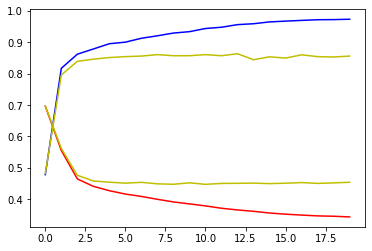

In [0]:
## NN tuning

train_features_torch = torch.tensor(train_features).to(device)
train_labels_torch = torch.tensor(train_labels).to(device)
test_features_torch = torch.tensor(test_features).to(device)
test_labels_torch = torch.tensor(test_labels).to(device)

fn = ffn(train_features.shape[1])
fn.to(device)

opt = optim.Adam(fn.parameters(), lr=0.00002, weight_decay=0.000000001)
do_validation = True
print(fit(train_features_torch, train_labels_torch, fn, opt, loss_fn, do_validation, test_features_torch, test_labels_torch, epochs=2000))
print(accuracy(fn(test_features_torch), test_labels_torch).item())

## Use Fine-tuned DistilBertModel to get sentence vector by taking average of all the word vectors or concating all the word vectors

In [0]:
tokenizer = DistilBertTokenizer.from_pretrained('model_path')

tokenized = [tokenizer.encode(element, add_special_tokens=True) for element in df[0]]

## Padding
max_len = 0

for value in tokenized:
  if len(value) > max_len:
    max_len = len(value)

tokenized = np.array([i + [0]*(max_len - len(i)) for i in tokenized])
print(tokenized.shape)

## Attention Mark
attention_mask = np.where(tokenized != 0, 1, 0)

## labels
labels = df[1].values

batch_size=32

tokenized = torch.tensor(tokenized).to(device)
attention_mask = torch.tensor(attention_mask).to(device)
labels = torch.tensor(labels).to(device)

training_data = TensorDataset(tokenized, attention_mask, labels)
train_sampler = RandomSampler(training_data)
train_dataloader = DataLoader(training_data, sampler=train_sampler, batch_size=batch_size)

model = DistilBertModel.from_pretrained('model_path')
model.cuda()

features = []
feature_labels = []
for step, batch in enumerate(train_dataloader):

  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      last_hidden_states = model(b_input_ids, attention_mask=b_input_mask)

  # print(last_hidden_states[0][:,1:,:].size())
  # print(last_hidden_states[0][:,1:,:].sum(dim=1).size())

  if step==0:
    features = last_hidden_states[0][:,:,:].cpu().numpy()
    feature_labels = b_labels.cpu().numpy()
  else:
    features = np.concatenate((features, last_hidden_states[0][:,:,:].cpu().numpy()), axis=0)
    feature_labels = np.concatenate((feature_labels, b_labels.cpu().numpy()), axis=0)


(6920, 67)


In [0]:
print(features.shape)

features_average = np.sum(features, axis=1) / 67  ## normalizing after adding 66 word embedding to generate sentence vector
print(features_average.shape)

features_concat = features.reshape(features.shape[0],-1)
print(features_concat.shape)

(6920, 67, 768)
(6920, 768)
(6920, 51456)


### Sentence Vector generation by averaging all the word embedding

In [0]:
train_features, test_features, train_labels, test_labels = train_test_split(features_average, feature_labels, stratify=feature_labels, random_state=42)
print(train_features.shape, train_labels.shape)

lr_clf = LogisticRegression(C=5, solver='lbfgs')
lr_clf.fit(train_features, train_labels)

# parameters = {'C': np.linspace(0.0001, 100, 20)}
# grid_search = GridSearchCV(LogisticRegression(), parameters)
# grid_search.fit(train_features, train_labels)

# print('best parameters: ', grid_search.best_params_)
# print('best scrores: ', grid_search.best_score_)

print(lr_clf.score(test_features, test_labels))
print(lr_clf.score(train_features, train_labels))

xgb_model = XGBClassifier(max_depth=3)
xgb_model.fit(train_features, train_labels)

pred = xgb_model.predict(test_features)
print(accuracy_score(test_labels, pred))

pred = xgb_model.predict(train_features)
print(accuracy_score(train_labels, pred))

(5190, 768) (5190,)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.8514450867052024
0.8913294797687862
0.8202312138728324
0.9127167630057803


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.9581888318061829
0.8508670330047607


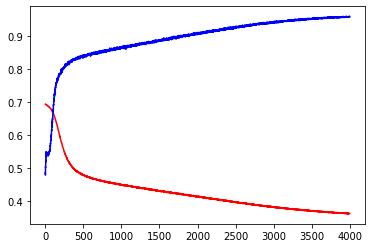

In [0]:
## NN tuning

train_features_torch = torch.tensor(train_features).to(device)
train_labels_torch = torch.tensor(train_labels).to(device)
test_features_torch = torch.tensor(test_features).to(device)
test_labels_torch = torch.tensor(test_labels).to(device)

fn = ffn(train_features.shape[1])
fn.to(device)

opt = optim.Adam(fn.parameters(), lr=0.00001, weight_decay=0.000000001)
print(fit(train_features_torch, train_labels_torch, fn, opt, loss_fn, epochs=4000))
print(accuracy(fn(test_features_torch), test_labels_torch).item())

### Sentence Vector generation by concatenating all the word embedddings

In [0]:
train_features, test_features, train_labels, test_labels = train_test_split(features_concat, feature_labels, stratify=feature_labels, random_state=42)
print(train_features.shape, train_labels.shape)

pca = PCA(0.99)
pca.fit(train_features)
train_features_pca = pca.transform(train_features)
test_features_pca = pca.transform(test_features)
# print(pca.explained_variance_ratio_)
print(train_features_pca.shape, test_features_pca.shape)

lr_clf = LogisticRegression(C=5, solver = 'lbfgs')
lr_clf.fit(train_features_pca, train_labels)

# parameters = {'C': np.linspace(0.0001, 100, 20)}
# grid_search = GridSearchCV(LogisticRegression(), parameters)
# grid_search.fit(train_features, train_labels)

# print('best parameters: ', grid_search.best_params_)
# print('best scrores: ', grid_search.best_score_)

print(lr_clf.score(test_features_pca, test_labels))
print(lr_clf.score(train_features_pca, train_labels))

# xgb_model = XGBClassifier(max_depth=3)
# xgb_model.fit(train_features, train_labels)

# pred = xgb_model.predict(test_features)
# print(accuracy_score(test_labels, pred))

# pred = xgb_model.predict(train_features)
# print(accuracy_score(train_labels, pred))

(5190, 51456) (5190,)
(5190, 4486) (1730, 4486)
0.8167630057803468
1.0


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.9998072981834412
tensor(0.8179, device='cuda:0')


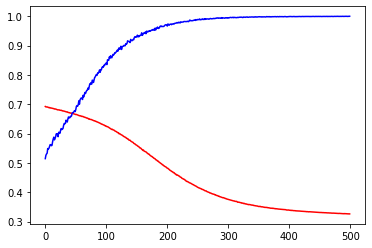

In [0]:
## NN tuning

train_features_torch = torch.tensor(train_features_pca).to(device)
train_labels_torch = torch.tensor(train_labels).to(device)
test_features_torch = torch.tensor(test_features_pca).to(device)
test_labels_torch = torch.tensor(test_labels).to(device)

fn = ffn(train_features_pca.shape[1])
fn.to(device)

opt = optim.Adam(fn.parameters(), lr=0.00001, weight_decay=0.000000001)
print(fit(train_features_torch, train_labels_torch, fn, opt, loss_fn, epochs=450))
print(accuracy(fn(test_features_torch), test_labels_torch))